In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

In [3]:
# Path to your file (change this to your actual path)
file_path = r"D:\GIT hub projects\Forcasting\EnergyData.csv"

# Load CSV and parse DateTime
df = pd.read_csv(file_path, parse_dates=["DateTime"])

# Set DateTime as index
df.set_index("DateTime", inplace=True)

# Inspect the first rows
print(df.head())
print(df.info())


                     MT_001  MT_002  MT_003  MT_004  MT_005  MT_006  MT_007  \
DateTime                                                                      
2011-01-01 00:15:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2011-01-01 00:30:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2011-01-01 00:45:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2011-01-01 01:00:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2011-01-01 01:15:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

                     MT_008  MT_009  MT_010  ...  MT_361  MT_362  MT_363  \
DateTime                                     ...                           
2011-01-01 00:15:00     0.0     0.0     0.0  ...     0.0       0     0.0   
2011-01-01 00:30:00     0.0     0.0     0.0  ...     0.0       0     0.0   
2011-01-01 00:45:00     0.0     0.0     0.0  ...     0.0       0     0.0   
2011-01-01 01:00:00     0.0     0.0     0.0  ...     0.0       0  

In [3]:
# Basic statistics
df.shape
df.isnull().sum().sum()
df.describe().iloc[:, :10]

# Drop columns that are completely zero
df = df.loc[:, (df != 0).any(axis=0)]

# data frequency
df.index.to_series().diff().value_counts().head()

print(f"Shape after dropping all-zero columns: {df.shape}")

Shape after dropping all-zero columns: (140256, 370)


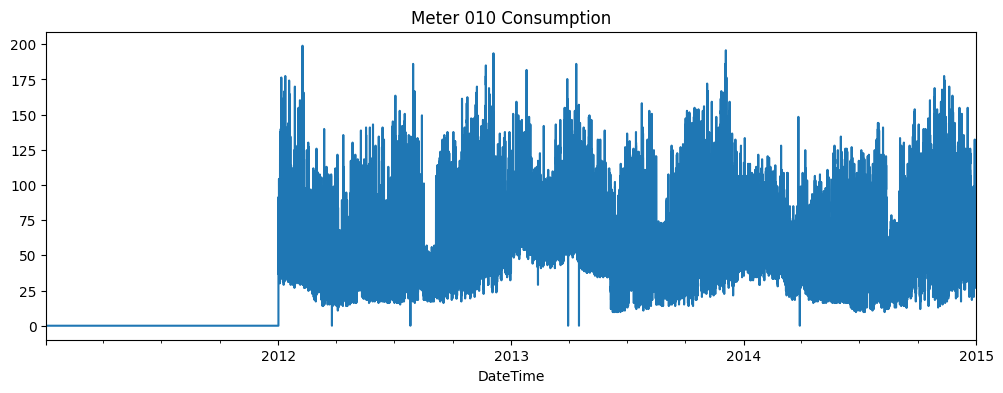

In [8]:
import matplotlib.pyplot as plt

df["MT_010"].plot(figsize=(12,4), title="Meter 010 Consumption")
plt.show()

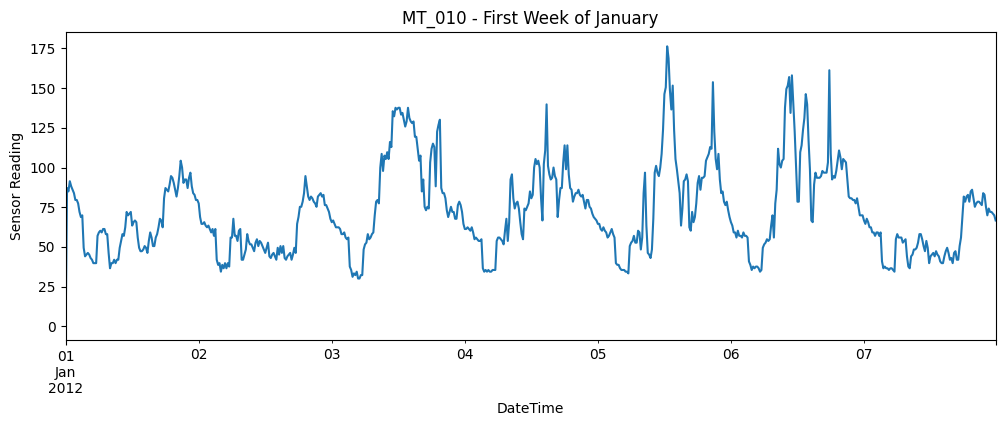

In [9]:
df['MT_010'].loc['2012-01-01':'2012-01-07'].plot(figsize=(12, 4), title='MT_010 - First Week of January')
plt.ylabel('Sensor Reading')
plt.show()

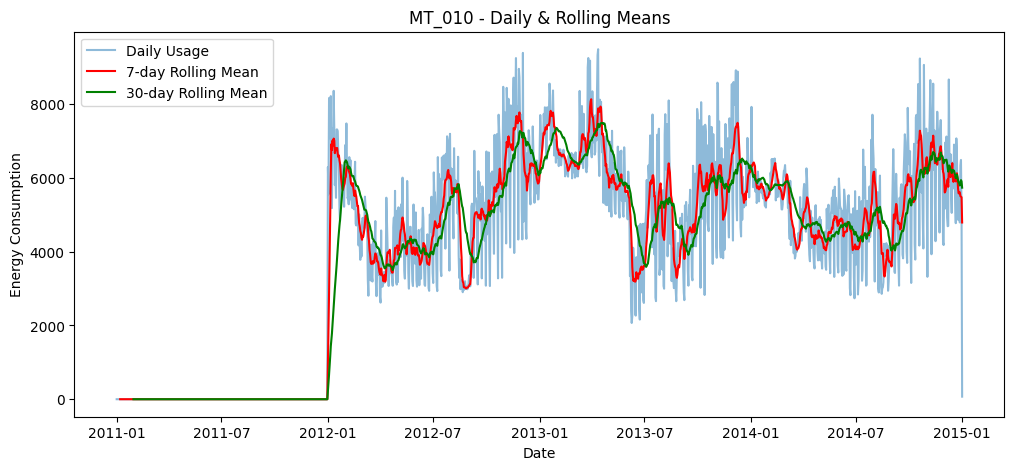

In [10]:

# Example: daily and weekly seasonality
meter = "MT_010"

plt.figure(figsize=(12,5))
plt.plot(df_daily.index, df_daily[meter], alpha=0.5, label="Daily Usage")
plt.plot(df_daily[meter].rolling(window=7).mean(), label="7-day Rolling Mean", color="red")
plt.plot(df_daily[meter].rolling(window=30).mean(), label="30-day Rolling Mean", color="green")
plt.title(f"{meter} - Daily & Rolling Means")
plt.xlabel("Date")
plt.ylabel("Energy Consumption")
plt.legend()
plt.show()




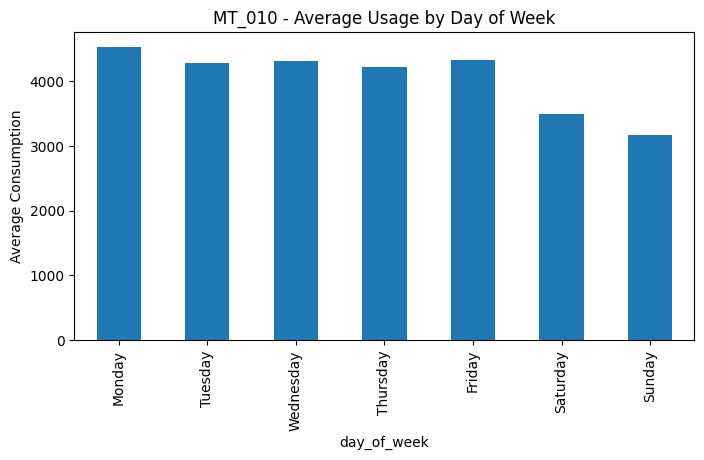

In [11]:
df_daily['day_of_week'] = df_daily.index.day_name()
weekly_avg = df_daily.groupby('day_of_week')[meter].mean().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])

weekly_avg.plot(kind='bar', figsize=(8,4), title=f"{meter} - Average Usage by Day of Week")
plt.ylabel("Average Consumption")
plt.show()


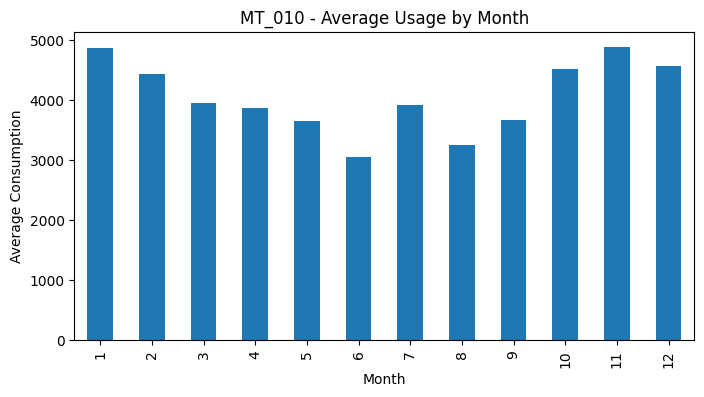

In [12]:
df_daily['month'] = df_daily.index.month
monthly_avg = df_daily.groupby('month')[meter].mean()

monthly_avg.plot(kind='bar', figsize=(8,4), title=f"{meter} - Average Usage by Month")
plt.ylabel("Average Consumption")
plt.xlabel("Month")
plt.show()


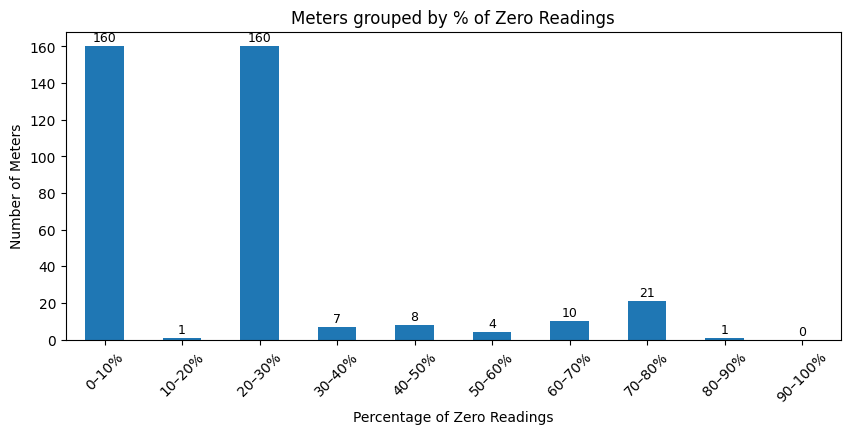

In [14]:


zero_ratio = (df_daily == 0).mean()

# drop rolling columns if present
zr = zero_ratio.drop("MT_010_roll", errors="ignore")

# define bins and labels
bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
labels = ["0–10%", "10–20%", "20–30%", "30–40%", "40–50%", 
          "50–60%", "60–70%", "70–80%", "80–90%", "90–100%"]

# categorize
zr_binned = pd.cut(zr, bins=bins, labels=labels, include_lowest=True)

# count frequency
counts = zr_binned.value_counts().sort_index()

# plot
ax = counts.plot(kind="bar", figsize=(10,4), rot=45, title="Meters grouped by % of Zero Readings")
plt.ylabel("Number of Meters")
plt.xlabel("Percentage of Zero Readings")

# add numbers above bars
for i, v in enumerate(counts):
    ax.text(i, v + 1, str(v), ha='center', va='bottom', fontsize=9)

plt.show()


In [15]:
# drop rolling columns if present
zr = zero_ratio.drop("MT_010_roll", errors="ignore")

# define bins and labels
bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
labels = ["0–10%", "10–20%", "20–30%", "30–40%", "40–50%", 
          "50–60%", "60–70%", "70–80%", "80–90%", "90–100%"]

# categorize each meter into a bin
zr_binned = pd.cut(zr, bins=bins, labels=labels, include_lowest=True)

# group meters by bin
grouped_meters = zr.groupby(zr_binned).apply(lambda x: list(x.index))

# print nicely
for group, meters in grouped_meters.items():
    print(f"{group} ({len(meters)} meters): {meters}")


0–10% (160 meters): ['MT_124', 'MT_131', 'MT_156', 'MT_158', 'MT_159', 'MT_161', 'MT_162', 'MT_163', 'MT_164', 'MT_166', 'MT_168', 'MT_169', 'MT_171', 'MT_172', 'MT_174', 'MT_175', 'MT_176', 'MT_180', 'MT_182', 'MT_183', 'MT_187', 'MT_188', 'MT_189', 'MT_190', 'MT_191', 'MT_192', 'MT_193', 'MT_194', 'MT_195', 'MT_196', 'MT_197', 'MT_198', 'MT_199', 'MT_200', 'MT_201', 'MT_202', 'MT_203', 'MT_204', 'MT_205', 'MT_206', 'MT_207', 'MT_208', 'MT_209', 'MT_210', 'MT_211', 'MT_212', 'MT_213', 'MT_214', 'MT_215', 'MT_216', 'MT_217', 'MT_218', 'MT_219', 'MT_220', 'MT_221', 'MT_222', 'MT_225', 'MT_226', 'MT_227', 'MT_228', 'MT_229', 'MT_230', 'MT_231', 'MT_232', 'MT_233', 'MT_234', 'MT_235', 'MT_236', 'MT_237', 'MT_238', 'MT_239', 'MT_240', 'MT_241', 'MT_242', 'MT_243', 'MT_244', 'MT_245', 'MT_246', 'MT_247', 'MT_248', 'MT_249', 'MT_250', 'MT_251', 'MT_252', 'MT_253', 'MT_254', 'MT_256', 'MT_257', 'MT_258', 'MT_259', 'MT_260', 'MT_261', 'MT_262', 'MT_263', 'MT_264', 'MT_265', 'MT_266', 'MT_267',

C:\Users\hasan\AppData\Local\Temp\ipykernel_13652\770159477.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_meters = zr.groupby(zr_binned).apply(lambda x: list(x.index))


In [16]:
# MEter status
meter_status = {col: ("MA" if zero_frac < 0.5 else "MI") for col, zero_frac in zr.items()}

# Example usage
meter = "MT_050"
print(f"{meter} is {meter_status[meter]}")


MT_050 is MA


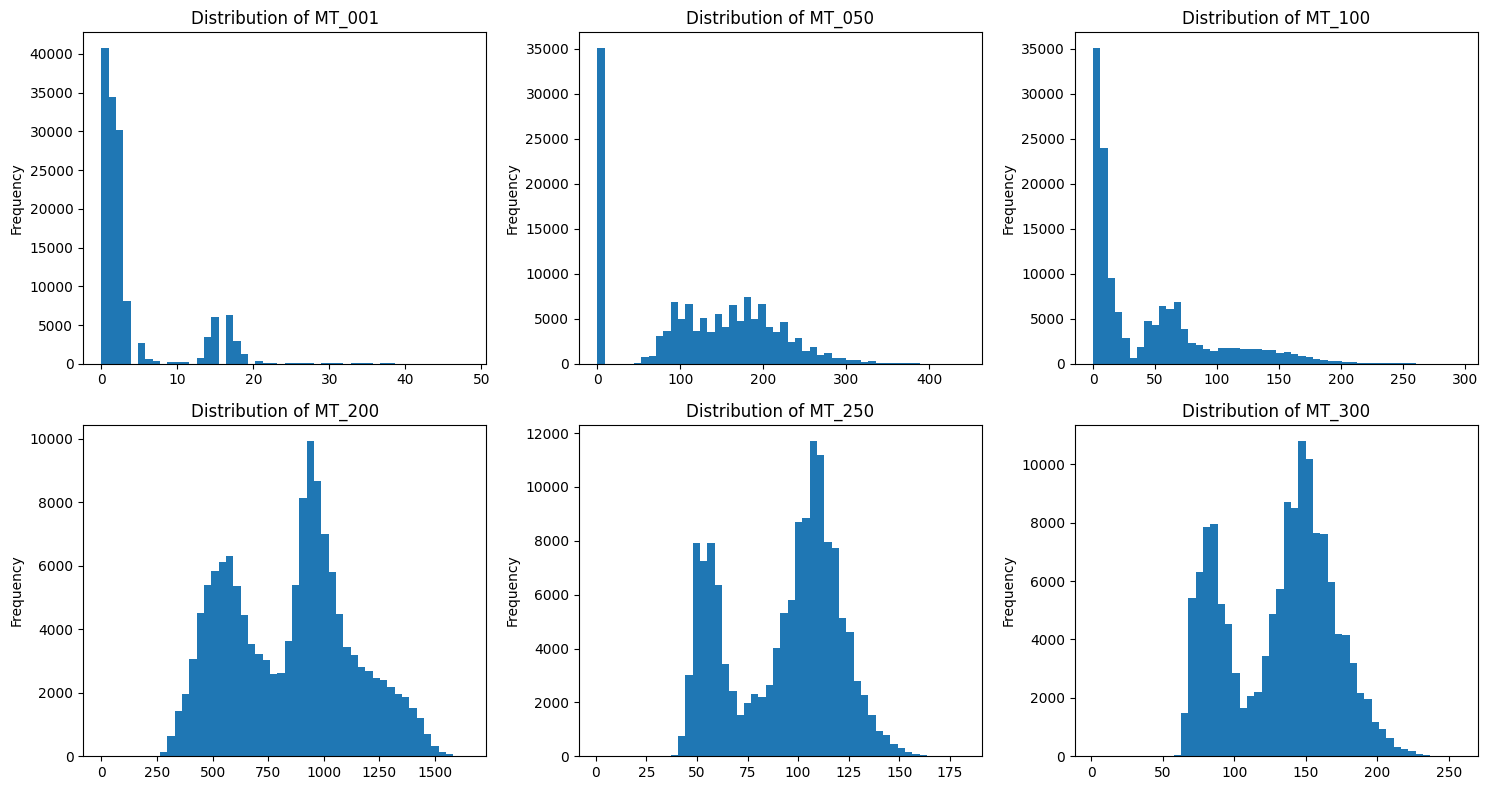

In [17]:
# pick the columns you want
cols_to_plot = ['MT_001', 'MT_050', 'MT_100', 'MT_200', 'MT_250', 'MT_300']

# create subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 8))  # 2 rows, 3 columns
axes = axes.flatten()  # flatten to 1D array for easy indexing

for i, col in enumerate(cols_to_plot):
    df[col].plot(kind='hist', bins=50, ax=axes[i], title=f'Distribution of {col}')

plt.tight_layout()
plt.show()


In [ ]:
# Convert meter_status dict to DataFrame
status_df = pd.DataFrame(list(meter_status.items()), columns=['meter', 'status'])

# Merge with meter_clusters (assuming meter_clusters has at least 'meter' and 'cluster')
meter_clusters = meter_clusters.merge(status_df, on='meter', how='left')

print(meter_clusters.head())


    meter status_x  cluster status_y status
0  MT_001       MA        0       MA     MA
1  MT_002       MA        0       MA     MA
2  MT_003       MA        0       MA     MA
3  MT_004       MA        0       MA     MA
4  MT_005       MA        0       MA     MA


Meter status counts:
 MA    331
MI     39
Name: count, dtype: int64
    meter status  cluster
0  MT_001     MA        0
1  MT_002     MA        0
2  MT_003     MA        0
3  MT_004     MA        0
4  MT_005     MA        0
5  MT_006     MA        0
6  MT_007     MA        0
7  MT_008     MA        0
8  MT_009     MA        0
9  MT_010     MA        0


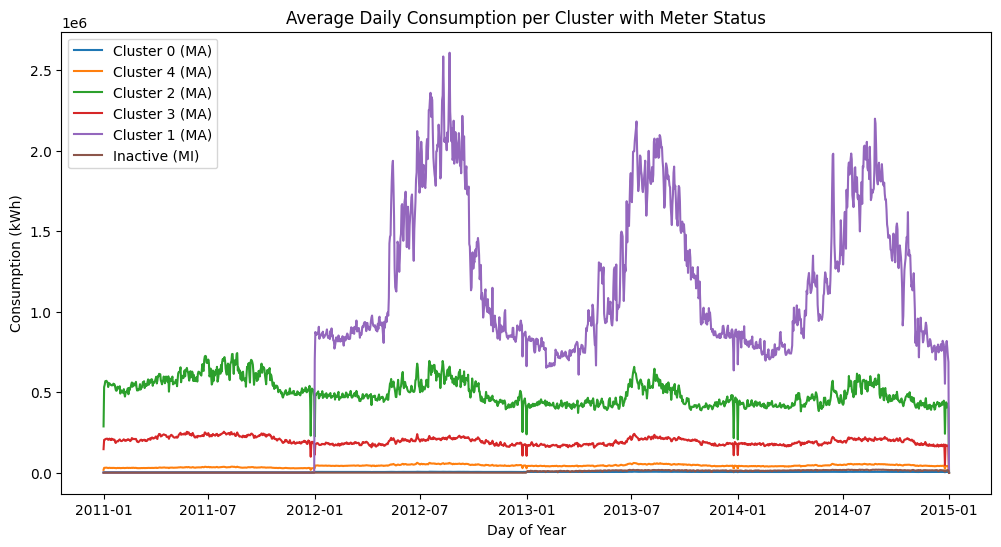

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# -----------------------------
# 1. Daily aggregation (df_clean has DateTime index)
# -----------------------------
df_daily = df_clean.resample("D").sum()

# -----------------------------
# 2. Compute meter status (mostly active / mostly inactive)
# -----------------------------
zero_ratio = (df_daily == 0).mean()
threshold_inactive = 0.5  # >=50% zeros → mostly inactive

meter_status = pd.Series(index=df_daily.columns, dtype=str)
meter_status[zero_ratio >= threshold_inactive] = 'MI'  # Mostly Inactive
meter_status[zero_ratio < threshold_inactive] = 'MA'   # Mostly Active

print("Meter status counts:\n", meter_status.value_counts())

# -----------------------------
# 3. Cluster mostly active meters
# -----------------------------
active_meters = meter_status[meter_status == 'MA'].index
X = df_daily[active_meters].T  # rows = meters, columns = days

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA for dimensionality reduction
pca = PCA(n_components=20)
X_pca = pca.fit_transform(X_scaled)

# K-Means clustering
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X_pca)

# -----------------------------
# 4. Combine cluster labels and meter status
# -----------------------------
meter_clusters = pd.DataFrame({
    'meter': active_meters,
    'status': 'MA',
    'cluster': clusters
})

# Add mostly inactive meters as cluster -1
inactive_meters = meter_status[meter_status == 'MI'].index
inactive_df = pd.DataFrame({
    'meter': inactive_meters,
    'status': 'MI',
    'cluster': -1
})

meter_clusters = pd.concat([meter_clusters, inactive_df], ignore_index=True)
print(meter_clusters.head(10))

# -----------------------------
# 5. Plot average daily consumption per cluster with meter status
# -----------------------------
plt.figure(figsize=(12,6))

for c in meter_clusters['cluster'].unique():
    meters_in_cluster = meter_clusters[meter_clusters['cluster']==c]['meter']
    if len(meters_in_cluster) == 0:
        continue
    cluster_avg = df_daily[meters_in_cluster].mean(axis=1)
    
    # Label cluster: inactive or mostly active
    if c == -1:
        label = 'Inactive (MI)'
    else:
        # Get most common status in cluster (should be MA)
        status = meter_clusters.loc[meter_clusters['meter'].isin(meters_in_cluster), 'status'].mode()[0]
        label = f'Cluster {c} ({status})'
    
    plt.plot(cluster_avg, label=label)

plt.title('Average Daily Consumption per Cluster with Meter Status')
plt.xlabel('Day of Year')
plt.ylabel('Consumption (kWh)')
plt.legend()
plt.show()

In [11]:
# Calculate average daily consumption for each cluster
cluster_means = {}

for c in meter_clusters['cluster'].unique():
    meters_in_cluster = meter_clusters[meter_clusters['cluster']==c]['meter']
    cluster_avg = df_daily[meters_in_cluster].mean(axis=1)  # mean across meters per day
    cluster_means[c] = cluster_avg

# Convert to DataFrame (columns = clusters, index = dates)
cluster_means_df = pd.DataFrame(cluster_means)

print(cluster_means_df.head())


                      0             4              2              3    1  \
DateTime                                                                   
2011-01-01  1742.344526  18076.387238  287552.083322  146227.551224  0.0   
2011-01-02  2893.758587  30107.688692  532260.416665  204311.509408  0.0   
2011-01-03  2907.440268  30427.228849  545906.249995  204212.281590  0.0   
2011-01-04  2948.774904  30752.607600  568354.166670  208023.484870  0.0   
2011-01-05  2968.481695  30811.086239  567791.666668  210194.767370  0.0   

                    -1  
DateTime                
2011-01-01  273.179487  
2011-01-02  421.230769  
2011-01-03  459.094017  
2011-01-04  465.247863  
2011-01-05  468.478632  


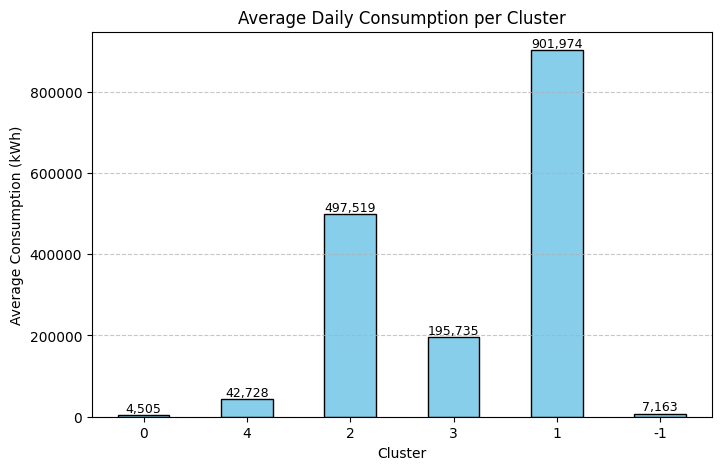

In [17]:
import matplotlib.pyplot as plt

overall_cluster_means = cluster_means_df.mean()

plt.figure(figsize=(8,5))
overall_cluster_means.plot(kind="bar", color="skyblue", edgecolor="black")

plt.title("Average Daily Consumption per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Average Consumption (kWh)")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)

for i, val in enumerate(overall_cluster_means):
    plt.text(i, val, f"{val:,.0f}", ha="center", va="bottom", fontsize=9)

plt.show()

